In [65]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from scipy import optimize, spatial
import os
import urllib

import frigidum

from frigidum.examples import tsp



In [47]:
eps = 0.0001
np.random.seed(42)

delta = np.random.rand(1001)

def produce_function(x):
    return 1 / (x**2 - 3*x + 2)

x = np.linspace(0, 3, 1001)
y = np.zeros(1001)
for i, xi in enumerate(x):
    f_x = produce_function(xi)
    if f_x < -100:
        y[i] = -100 + delta[i]
    elif -100 <= f_x <= 100:
        y[i] = f_x + delta[i]
    else:
        y[i] = 100 + delta[i]

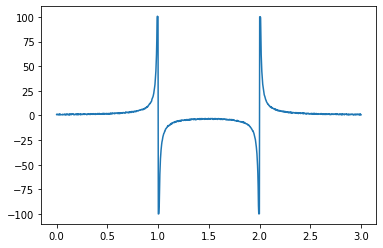

In [48]:
plt.plot(x, y)

In [49]:
def rational_function(x, a, b, c, d):
    return (a*x + b) / (x**2 + c * x + d)

def cost_func_vect(params, gt, x):
    a, b, c, d = params

    value = (gt - rational_function(x, a, b, c, d))
    return value

def cost_func(params, gt, x):
    a, b, c, d = params

    value = sum((gt - rational_function(x, a, b, c, d))**2)
    return value

Levenberg Markquardt: solution [-1.58925238  1.58046878 -1.97291701  0.97437757], # function evaluations 86
Nelder Mead: solution [-0.01639876  0.01404812 -2.01994314  1.02006443], # function evaluations 548, # iters 318
Annealing: solution [-1.00081082  1.00129558 -2.00087983  1.00089594], # function evaluations 9211, # iters 1000
Differential evolution: solution [-0.99800536  0.99848361 -2.0008851   1.00090111], # function evaluations 8935, # iters 147


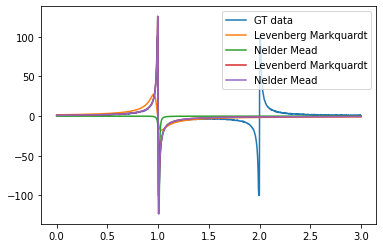

In [50]:
params_lm = optimize.least_squares(cost_func_vect, [1, 0, 1, 1], args=(y, x), method='lm', xtol=eps)
print(f'Levenberg Markquardt: solution {params_lm.x}, # function evaluations {params_lm.nfev}')
params_nm= optimize.minimize(cost_func, [1, 0, 1, 1], args=(y, x), method='Nelder-Mead', tol=eps)
print(f'Nelder Mead: solution {params_nm.x}, # function evaluations {params_nm.nfev}, # iters {params_nm.nit}')
params_anneal = optimize.dual_annealing(cost_func, ((-5, 5), (-5, 5), (-5, 5), (-5, 5)), args=(y, x))
print(f'Annealing: solution {params_anneal.x}, # function evaluations {params_anneal.nfev}, # iters {params_anneal.nit}')

params_evol = optimize.differential_evolution(cost_func, ((-5, 5), (-5, 5), (-5, 5), (-5, 5)), args=(y, x), tol=eps)
print(f'Differential evolution: solution {params_evol.x}, # function evaluations {params_evol.nfev}, # iters {params_evol.nit}')

plt.plot(x, y)
plt.plot(x, rational_function(x, *params_lm.x))
plt.plot(x, rational_function(x, *params_nm.x))
plt.plot(x, rational_function(x, *params_anneal.x))
plt.plot(x, rational_function(x, *params_evol.x))
plt.legend(['GT data', 'Levenberg Markquardt', 'Nelder Mead', 'Levenberd Markquardt', 'Nelder Mead'])


(442, 2)
[[   0.          100.          200.         ... 2370.35862266
   557.31499172  447.2135955 ]
 [ 100.            0.          100.         ... 2359.36432117
   550.09090158  538.51648071]
 [ 200.          100.            0.         ... 2352.57305944
   560.8921465   632.45553203]
 ...
 [2370.35862266 2359.36432117 2352.57305944 ...    0.
  1813.39460681 2646.99829996]
 [ 557.31499172  550.09090158  560.8921465  ... 1813.39460681
     0.          895.87945618]
 [ 447.2135955   538.51648071  632.45553203 ... 2646.99829996
   895.87945618    0.        ]]


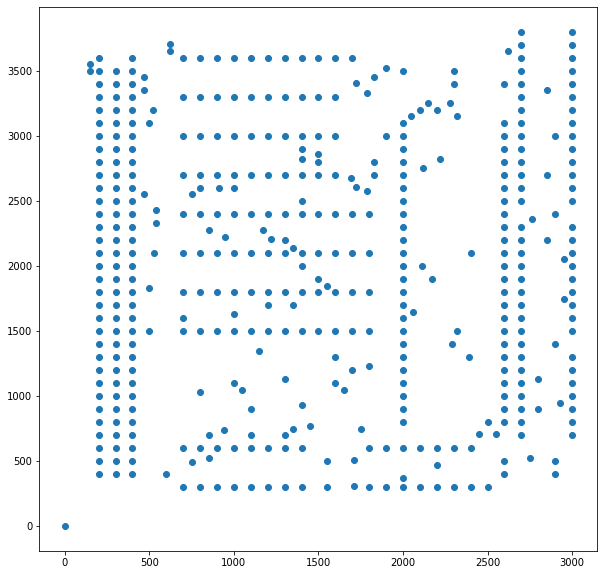

In [66]:
cities_filename = 'pcb442.tsp'
cities_link = 'http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/pcb442.tsp'

if not os.path.exists(cities_filename):
    urllib.request.urlretrieve(cities_link, cities_filename)

with open(cities_filename) as input_file:
    data = input_file.readlines()[6:-1]
data = [line.strip() for line in data]
data = [[line.split(' ')[1].strip(), line.split(' ')[2].strip()] for line in data]
data = np.array(data, dtype=float)
print(data.shape)
dist_matrix = spatial.distance.squareform(spatial.distance.pdist(data))
print(dist_matrix)




Text(0, 0.5, 'y')

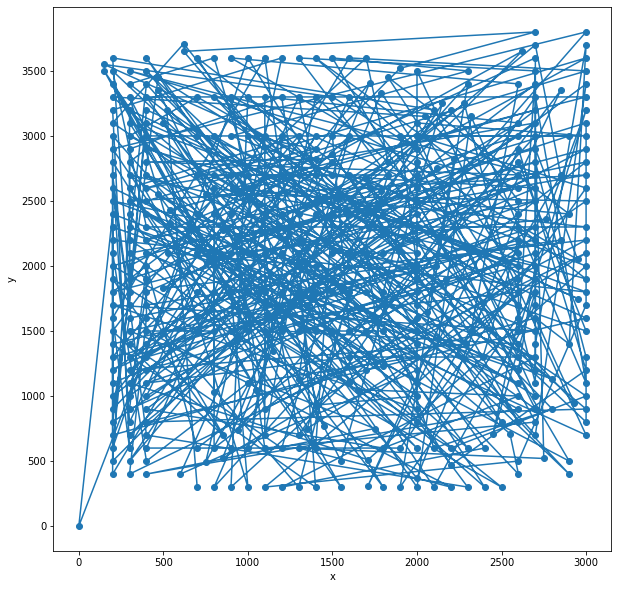

In [73]:
def rand_start():
    random_guess = np.arange(0, data.shape[0])
    np.random.seed(42)
    np.random.shuffle(random_guess)
    return random_guess
initial_guess = rand_start()
plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0][initial_guess], data[:, 1][initial_guess], )
plt.plot(data[:, 0][initial_guess], data[:, 1][initial_guess], )
plt.xlabel('x')
plt.ylabel('y')

In [72]:


local_opt = frigidum.sa(random_start=rand_start,
           objective_function=tsp.objective_function,
           neighbours=[tsp.euclidian_bomb_and_fix, tsp.euclidian_nuke_and_fix, tsp.route_bomb_and_fix, tsp.route_nuke_and_fix, tsp.random_disconnect_vertices_and_fix],
           copy_state=frigidum.annealing.naked,
           T_start=10**5,
           alpha=.92,
           T_stop=0.001,
           repeats=10**2,
           post_annealing=None)


T: 0.001, M: 0.02, O_min: 52678.6681, O_current: 52678.6681: 100%|██████████| 221/221 [03:05<00:00,  1.19cooling/s]

---
Neighbour Statistics: 
(proportion of proposals which got accepted *and* changed the objective function)
   euclidian_bomb_and_fix           : 0.214898
   euclidian_nuke_and_fix           : 0.253217
   route_bomb_and_fix               : 0.252730
   route_nuke_and_fix               : 0.255338
   random_disconnect_vertices_and_  : 0.131537
---
(Local) Minimum Objective Value Found: 
   52676.36284337


solution: [380 381 377  86  87  88  89  90  58  57  56  55  22  23  24  25  59  26
  27  93  94  95 379 378 111 123 133 146 158 169 182 197 208 218 217 207
 206 205 194 195 196 181 168 157 145 132 122 110 435 100  92  91  60  61
  28  29  62  63  30  31 375 376  32  64  96  97 383 382 112 124 134 147
 159 170 183 198 209 219 225 410 409 413 236 264 436 274 422 437 271 419
 267 415 263 262 235 261 412 411 407 408 403 216 204 193 180 167 156 144
 143 390 131 121 109 120 384 108 119 130 142 155 166 179 191 192 203 215
 224 232 231 223 214 202 189 190 397 177 178 394 393 165 154 141 129 389
 387 118 107 438  82  50  81  80  47  79  99 106 117 128 140 153 164 163
 176 396 188 200 201 401 213 222 230 229 221 212 199 187 175 211 228 220
 210 402 406 400 405 227 234 239 269 276 273 270 266 240 241 242 243 244
 245 246 247 248 414 249 250 251 252 253 254 255 256 257 258 259 260 418
 421 301 326 327 302 303 328 329 304 305 330 331 332 333 306 334 335 426
 336 337 374 373 372 371 370 431 369 368 

Text(0, 0.5, 'y')

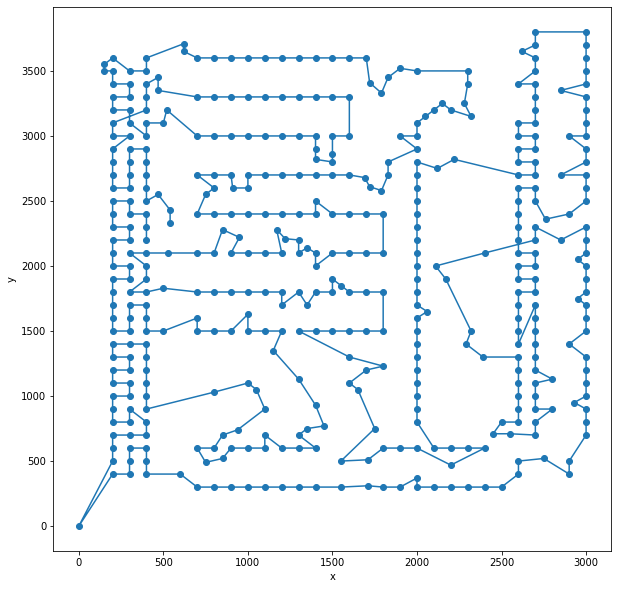

In [80]:
print('solution:', local_opt[0])
print('min temperature:', local_opt[1])
plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0][local_opt[0]], data[:, 1][local_opt[0]])
plt.plot(data[:, 0][local_opt[0]], data[:, 1][local_opt[0]])
plt.xlabel('x')
plt.ylabel('y')
